In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from scipy.stats import norm, truncnorm
import scipy.integrate as integrate

import gym
from gym import spaces

import random
import itertools as it
from joblib import Parallel, delayed
from toolz import memoize
from contracts import contract
from collections import namedtuple, defaultdict, deque, Counter

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

from agents import Agent
from truncoldmouselab import TruncOldMouselabEnv
from policies import FixedPlanPolicy, LiederPolicy
from evaluation import *
from distributions import *

In [2]:
import ipyparallel as ipp 
rc = ipp.Client(profile='default', cluster_id='')
ipp.register_joblib_backend()

# Utility Functions

In [3]:
def hd_dist(attributes):
    dist = [1,]*attributes
    dist[0] = np.random.randint(85,97)
    for i in range(1,attributes-1):
        dist[i] += np.random.randint(0,100-np.sum(dist))
    dist[-1] += 100-np.sum(dist)
    dist = np.around(np.array(dist)/100,decimals=2)
    np.random.shuffle(dist)
    return dist

def ld_dist(attributes):
    constrain = True
    while constrain:
        dist = [np.random.randint(10,50) for _ in range(attributes)]
        dist = np.around(np.array(dist)/sum(dist),decimals=2)
        constrain = np.min(dist) <= 0.10 or np.max(dist) >= 0.40
    np.random.shuffle(dist)
    return dist

# Truncated Normal Rewards

In [4]:
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)

In [5]:
x = np.linspace(-20,20,10000)
a,b = (0.01 - 5) /2.99, (9.99 - 5) / 2.99
y = truncnorm.pdf(x, a, b, loc=5, scale=2.99)

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


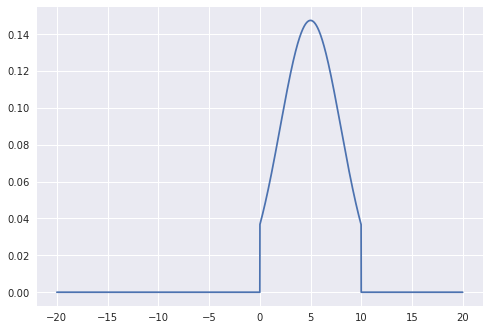

In [6]:
plt.plot(x,y)

In [7]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
reward = high_stakes
cost=.03

#set to 20 for sanity check
n_train = 20
n_test = 20

train_envs_ld = [TruncOldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]

test_envs_ld = [TruncOldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]

In [8]:
all_rewards = [] 
for env in train_envs_ld + test_envs_ld:
    rewards = env.ground_truth
    all_rewards.append(rewards) 

In [9]:
all_rewards = np.array(all_rewards)

In [10]:
np.min(all_rewards.flatten())

0.017633154046068356

(array([  60.,  102.,   96.,  125.,  164.,  178.,  146.,  106.,   88.,   55.]),
 array([ 0.018,  1.012,  2.006,  3.   ,  3.995,  4.989,  5.983,  6.977,  7.972,  8.966,  9.96 ]),
 <a list of 10 Patch objects>)

/global/software/sl-7.x86_64/modules/langs/python/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


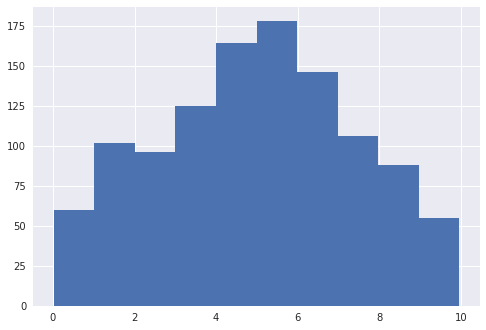

In [11]:
plt.hist(all_rewards.flatten())

In [12]:
np.mean(all_rewards)

4.9785691193766839

# Truncated Mouselab Environment

In [13]:
gambles = 4
attributes = [0.24,0.74,0.01,0.01]
reward = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
cost=0.03
env = TruncOldMouselabEnv(gambles, attributes, reward)

In [14]:
attributes = 4
env = TruncOldMouselabEnv(gambles, attributes, reward, cost, randomness=0.1)

In [15]:
env.action_features(4)

array([-0.03 , -2.5  ,  0.983,  2.415,  5.   ])

## Time features

In [16]:
import datetime

In [17]:
env.dist

array([  8.658e-05,   9.804e-01,   1.908e-02,   4.050e-04])

### VPI_all2

In [18]:
a = datetime.datetime.now()
means = []
for i in range(100):
    means.append(env.vpi2())
t = datetime.datetime.now() - a
print(np.mean(means))

2.46773505481


In [19]:
print(t)

0:02:35.903114


### VPI_action

In [20]:
a = datetime.datetime.now()
for i in range(100):
    env.vpi_action(2)
t = datetime.datetime.now() - a
print(t)

0:00:16.030954


### Myopic_VOI

In [21]:
a = datetime.datetime.now()
for i in range(100):
    env.myopic_voi(2)
t = datetime.datetime.now() - a
print(t)

0:00:03.175799


# Training

## High Stakes 1 cents

In [22]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = TruncatedNormal((9.99+0.01)/2, 0.3*(9.99-0.01),0.01,9.99)
low_stakes = TruncatedNormal((0.25+0.01)/2, 0.3*(0.25-0.01),0.01,0.25)
reward = high_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [TruncOldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [TruncOldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [TruncOldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [TruncOldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [ ]:
for env in train_envs_ld:
    dist = env.dist
    if np.min(dist) <= 0.10 or np.max(dist) >= 0.40:
        print('goshdarn')
        break

In [ ]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=100, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

In [ ]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

In [ ]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [ ]:
bo_pol.theta

In [ ]:
np.save('high_stakes_1cents',bo_pol.theta)

In [ ]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(bo_utils)

In [ ]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(mg_utils)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

In [ ]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(no_utils)

In [ ]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(fo_utils)

In [ ]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [ ]:
df = pd.DataFrame(d_list)
df

In [ ]:
df[df['policy'] == 'metagreedy'].util.mean()

In [ ]:
df.to_hdf('data/high_stakes_1cents_results','results')

In [ ]:
df2 = pd.read_hdf('data/high_stakes_1cents_results','results')

In [ ]:
df2[df2['policy']=='metagreedy'].util.mean()

## Low Stakes 1 cents

In [ ]:
gambles = 7
attributes = 4
# reward = Normal(0,1)
# max_obs=30
high_stakes = Normal((9.99+0.01)/2, 0.3*(9.99-0.01))
low_stakes = Normal((0.25+0.01)/2, 0.3*(0.25-0.01))
reward = low_stakes
cost=.01

#set to 20 for sanity check
n_train = 250
n_test = 250

train_envs_hd = [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
train_envs = train_envs_hd+train_envs_ld 

test_envs_hd =  [OldMouselabEnv(gambles, hd_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs_ld = [OldMouselabEnv(gambles, ld_dist(attributes), reward, cost) for _ in range(n_train)]
test_envs = test_envs_hd+test_envs_ld 

term_action = train_envs[0].term_action

In [ ]:
a = datetime.datetime.now()
# bop2 = bo_policy(train_envs, max_cost=max_obs, n_jobs=20, n_calls=20, x0=[1., 1., 0., 0.])
bo_pol, result = bo_policy(train_envs, max_cost=30, n_jobs=50, n_calls=20, x0=[1., 1., 0., 0.],
                           verbose=1, normalize_voi=True, return_result=True)
t = datetime.datetime.now() - a
print(t)

In [ ]:
# bo_pol_theta = np.load('low_stakes_0.5cents-2.npy')
# bo_pol = LiederPolicy(list(bo_pol_theta))

In [ ]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [ ]:
bo_pol.theta

In [ ]:
np.save('low_stakes_1cents',bo_pol.theta)

In [ ]:
a = datetime.datetime.now()
bo_utils = get_util(bo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(bo_utils)

In [ ]:
mg_pol = LiederPolicy([1, 1, 0, 0, 1])
a = datetime.datetime.now()
mg_utils = get_util(mg_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(mg_utils)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(bo_utils,mg_utils)

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(bo_utils,mg_utils)

In [ ]:
no_pol = FixedPlanPolicy([term_action])
a = datetime.datetime.now()
no_utils = get_util(no_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(no_utils)

In [ ]:
fo_pol = FixedPlanPolicy(range(term_action+1))
a = datetime.datetime.now()
fo_utils = get_util(fo_pol, test_envs, parallel=Parallel(n_jobs=20),return_mean=False)
t = datetime.datetime.now() - a

In [ ]:
np.mean(fo_utils)

In [ ]:
utils = [bo_utils,mg_utils,no_utils,fo_utils]
policies = ['bo','metagreedy','none','full-obs']
d_list = []
for u,p in zip(utils,policies):
    for result in u:
        d_list.append({'util':result,'stakes':'high','cost':cost,'policy':p})

In [ ]:
df = pd.DataFrame(d_list)
df

In [ ]:
df[df['policy'] == 'metagreedy'].util.mean()

In [ ]:
df.to_hdf('data/low_stakes_1cents_results','results')

In [ ]:
df2 = pd.read_hdf('data/low_stakes_1cents_results','results')

In [ ]:
df2[df2['policy']=='metagreedy'].util.mean()